
# 03 - Modular Enhancements

This notebook mirrors the Part 3 experiments but keeps the code lightweight by
relying on helper modules in `src/`.


## Imports & shared setup

In [1]:
from pathlib import Path

import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from IPython.display import Markdown, display
from dataclasses import replace, dataclass

from src.config import load_data_config
from src.dataset_pipeline import prepare_tokenised_splits
from src.embeddings import load_torchtext_glove
from src.reports import build_vocabulary_report
from src.models.birnn import BiLSTMClassifier, BiGRUClassifier
from src.models.cnn import CNNTextClassifier
from src.training import (
    RNNExperimentConfig,
    train_rnn_model,
    build_dataloaders_and_vocab,
    run_model_experiment,
    summarise_run,
)
from src.evaluation import evaluate_model, topic_accuracy_table, classification_report_table
from src.plotting import plot_training_curves

SEED = 7
sns.set_theme(style="whitegrid")

## Data & embeddings

In [2]:
data_config = load_data_config(Path('configs/data.yaml'))
splits = prepare_tokenised_splits(data_config)
len(splits.train), len(splits.validation), len(splits.test)

(4361, 1091, 500)

In [3]:
vocab_report = build_vocabulary_report(
    tokenised_dataset=splits.train,
    min_freq=data_config.vocabulary_min_freq,
    specials=data_config.vocabulary_specials,
)
embedding_result = load_torchtext_glove(
    vocabulary=vocab_report.vocabulary,
    name='6B',
    dim=100,
    trainable=True,
    random_seed=SEED,
)
embedding_tensor = torch.tensor(embedding_result.matrix, dtype=torch.float32)

## Shared experiment configuration

In [4]:
base_config = RNNExperimentConfig(
    epochs=15,
    batch_size=64,
    hidden_dim=128,
    num_layers=1,
    dropout=0.3,
    learning_rate=1e-3,
    weight_decay=1e-4,
    grad_clip=1.0,
    pooling='last_hidden',
    optimizer='adam',
    early_stopping_patience=3,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaders, label_to_index = build_dataloaders_and_vocab(base_config, splits, vocab_report.vocabulary)
records = {'rows': [], 'histories': {}, 'evaluations': {}, 'label_maps': {}}

## Baseline RNN

Baseline test accuracy: 0.556

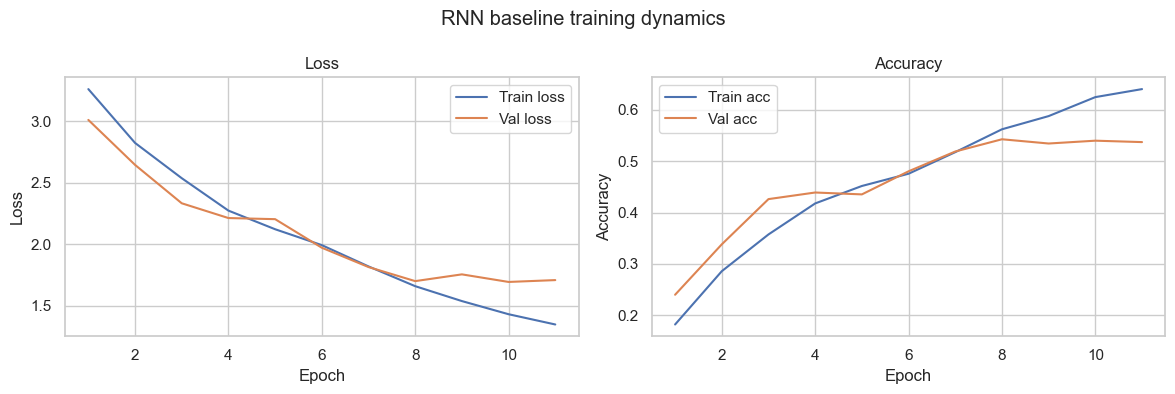

In [5]:
b_hist, b_model, b_label_map, b_loaders = train_rnn_model(
    base_config,
    splits=splits,
    vocabulary=vocab_report.vocabulary,
    embedding_result=embedding_result,
    device=device,
)
b_eval = evaluate_model(b_model, b_loaders.test, device=device)
records['histories']['rnn_baseline'] = b_hist
records['evaluations']['rnn_baseline'] = b_eval
records['label_maps']['rnn_baseline'] = b_label_map
records['rows'].append(summarise_run('rnn_baseline', b_hist, b_eval.accuracy))
plot_training_curves(
    b_hist,
    title='RNN baseline training dynamics',
    output_path=Path('plots/part3_rnn_baseline_curves.png'),
)
display(Markdown(f"Baseline test accuracy: {b_eval.accuracy:.3f}"))

## biLSTM

biLSTM test accuracy: 0.766

(<Figure size 1200x400 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

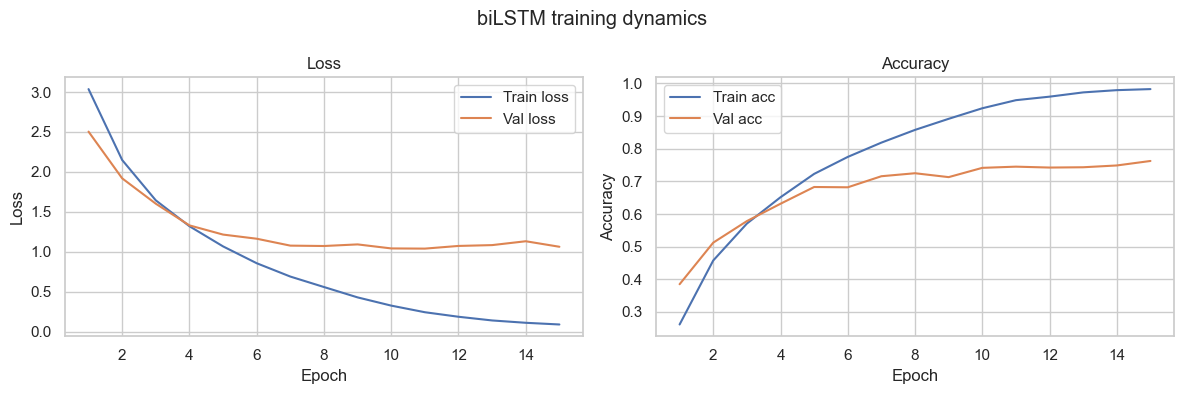

In [6]:
hist_bilstm, model_bilstm, eval_bilstm = run_model_experiment(
    'bilstm',
    model_builder=lambda: BiLSTMClassifier(
        embedding_matrix=embedding_tensor.clone(),
        num_classes=len(label_to_index),
        hidden_dim=base_config.hidden_dim,
        num_layers=base_config.num_layers,
        dropout=base_config.dropout,
    ),
    config=base_config,
    loaders=loaders,
    device=device,
)
records['histories']['bilstm'] = hist_bilstm
records['evaluations']['bilstm'] = eval_bilstm
records['label_maps']['bilstm'] = {idx: label for label, idx in label_to_index.items()}
records['rows'].append(summarise_run('bilstm', hist_bilstm, eval_bilstm.accuracy))
display(Markdown(f"biLSTM test accuracy: {eval_bilstm.accuracy:.3f}"))
plot_training_curves(
    hist_bilstm,
    title='biLSTM training dynamics',
    output_path=Path('plots/part3_bilstm_curves.png'),
)

## biGRU

biGRU test accuracy: 0.816

(<Figure size 1200x400 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

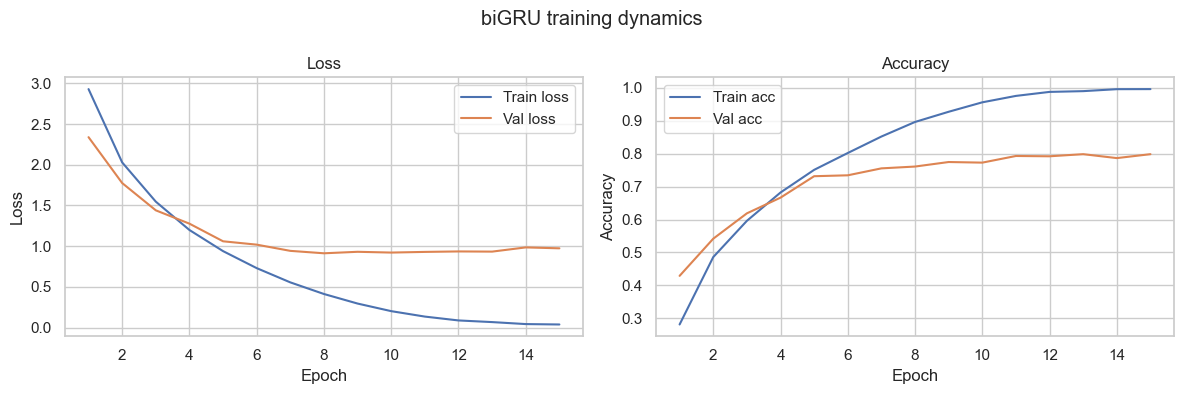

In [7]:
hist_bigru, model_bigru, eval_bigru = run_model_experiment(
    'bigru',
    model_builder=lambda: BiGRUClassifier(
        embedding_matrix=embedding_tensor.clone(),
        num_classes=len(label_to_index),
        hidden_dim=base_config.hidden_dim,
        num_layers=base_config.num_layers,
        dropout=base_config.dropout,
    ),
    config=base_config,
    loaders=loaders,
    device=device,
)
records['histories']['bigru'] = hist_bigru
records['evaluations']['bigru'] = eval_bigru
records['label_maps']['bigru'] = {idx: label for label, idx in label_to_index.items()}
records['rows'].append(summarise_run('bigru', hist_bigru, eval_bigru.accuracy))
display(Markdown(f"biGRU test accuracy: {eval_bigru.accuracy:.3f}"))
plot_training_curves(
    hist_bigru,
    title='biGRU training dynamics',
    output_path=Path('plots/part3_bigru_curves.png'),
)

## CNN

CNN test accuracy: 0.822

(<Figure size 1200x400 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

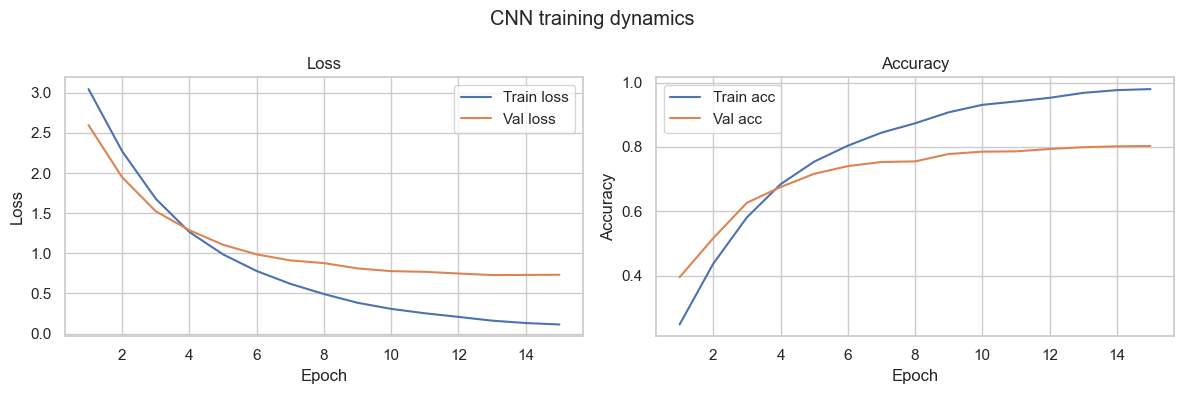

In [8]:
cnn_config = replace(base_config, dropout=0.5, weight_decay=0.0, grad_clip=0.0)
hist_cnn, model_cnn, eval_cnn = run_model_experiment(
    'cnn',
    model_builder=lambda: CNNTextClassifier(
        embedding_matrix=embedding_tensor.clone(),
        num_classes=len(label_to_index),
        dropout=cnn_config.dropout,
    ),
    config=cnn_config,
    loaders=loaders,
    device=device,
)
records['histories']['cnn'] = hist_cnn
records['evaluations']['cnn'] = eval_cnn
records['label_maps']['cnn'] = {idx: label for label, idx in label_to_index.items()}
records['rows'].append(summarise_run('cnn', hist_cnn, eval_cnn.accuracy))
display(Markdown(f"CNN test accuracy: {eval_cnn.accuracy:.3f}"))
plot_training_curves(
    hist_cnn,
    title='CNN training dynamics',
    output_path=Path('plots/part3_cnn_curves.png'),
)

## Summary & comparison

,best_epoch,val_accuracy,test_accuracy
name,,,
cnn,15,0.802933,0.822
bigru,13,0.798350,0.816
bilstm,15,0.762603,0.766
rnn_baseline,8,0.542621,0.556


Best model: **cnn** (test accuracy 0.822)

/var/folders/n9/nqt4flt92tgcz4q081zf11740000gn/T/ipykernel_52355/3071553650.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  accuracy_colors = [cm.get_cmap('viridis')(acc) for acc in best_topic_df['accuracy'].clip(0, 1)]
/var/folders/n9/nqt4flt92tgcz4q081zf11740000gn/T/ipykernel_52355/3071553650.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sm = plt.cm.ScalarMappable(cmap=cm.get_cmap('viridis'), norm=colors.Normalize(0, 1))


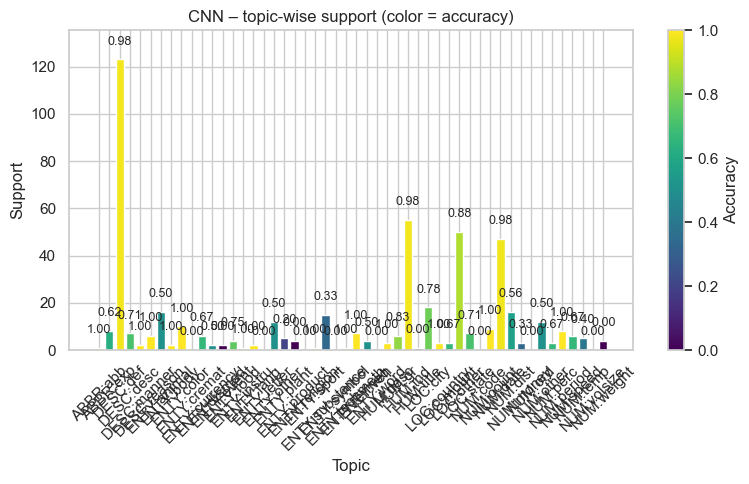

/var/folders/n9/nqt4flt92tgcz4q081zf11740000gn/T/ipykernel_52355/3071553650.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  support_colors = [cm.get_cmap('magma')(acc) for acc in label_rows['accuracy'].clip(0, 1)]
/var/folders/n9/nqt4flt92tgcz4q081zf11740000gn/T/ipykernel_52355/3071553650.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sm = plt.cm.ScalarMappable(cmap=cm.get_cmap('magma'), norm=colors.Normalize(0, 1))


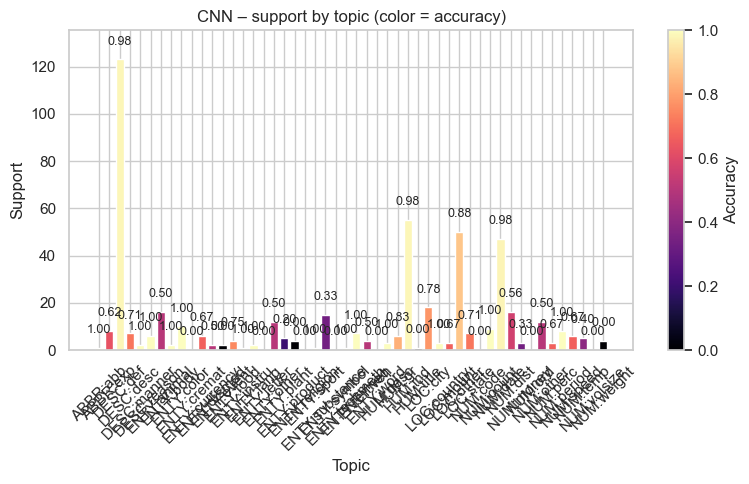

/var/folders/n9/nqt4flt92tgcz4q081zf11740000gn/T/ipykernel_52355/3071553650.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  f1_colors = [cm.get_cmap('plasma')(score) for score in label_rows['f1-score'].clip(0, 1)]


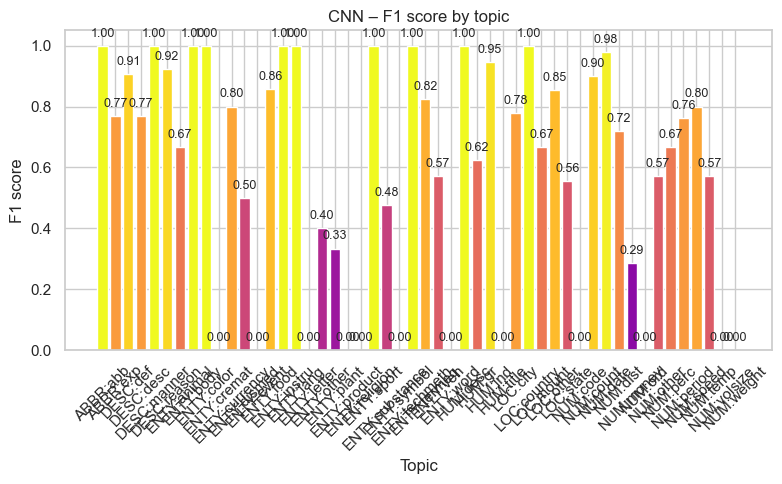

,precision,recall,f1-score,support
accuracy,0.822000,0.822000,0.822000,0.822
macro avg,0.634083,0.584696,0.589576,500.000
weighted avg,0.828928,0.822000,0.807329,500.000


In [9]:
comparison_df = pd.DataFrame(records['rows']).set_index('name').sort_values('test_accuracy', ascending=False)
display(comparison_df)

best_name = comparison_df.index[0]
best_eval = records['evaluations'][best_name]
best_history = records['histories'][best_name]
best_label_map = records['label_maps'][best_name]
display(Markdown(f"Best model: **{best_name}** (test accuracy {comparison_df.loc[best_name, 'test_accuracy']:.3f})"))

best_topic_df = topic_accuracy_table(best_eval, best_label_map)
fig, ax = plt.subplots(figsize=(8, 5))
accuracy_colors = [cm.get_cmap('viridis')(acc) for acc in best_topic_df['accuracy'].clip(0, 1)]
bars = ax.bar(best_topic_df['label'], best_topic_df['support'], color=accuracy_colors)
ax.set_xlabel('Topic')
ax.set_ylabel('Support')
ax.set_title(f"{best_name.upper()} – topic-wise support (color = accuracy)")
ax.set_ylim(0, best_topic_df['support'].max() * 1.1)
for bar, accuracy in zip(bars, best_topic_df['accuracy']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f"{accuracy:.2f}", ha='center', va='bottom', fontsize=9)
sm = plt.cm.ScalarMappable(cmap=cm.get_cmap('viridis'), norm=colors.Normalize(0, 1))
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
fig.savefig(f"plots/part3_{best_name}_topic_accuracy.png", dpi=300)
plt.show()

best_report_df = classification_report_table(best_eval, best_label_map)
label_rows = best_report_df.loc[~best_report_df.index.isin(['accuracy', 'macro avg', 'weighted avg', 'micro avg'])].copy()
if 'accuracy' not in label_rows.columns:
    label_rows['accuracy'] = label_rows.get('recall', 0.0)

fig, ax = plt.subplots(figsize=(8, 5))
support_colors = [cm.get_cmap('magma')(acc) for acc in label_rows['accuracy'].clip(0, 1)]
bars = ax.bar(label_rows.index, label_rows['support'], color=support_colors)
ax.set_xlabel('Topic')
ax.set_ylabel('Support')
ax.set_title(f"{best_name.upper()} – support by topic (color = accuracy)")
ax.set_ylim(0, label_rows['support'].max() * 1.1)
for bar, accuracy in zip(bars, label_rows['accuracy']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f"{accuracy:.2f}", ha='center', va='bottom', fontsize=9)
sm = plt.cm.ScalarMappable(cmap=cm.get_cmap('magma'), norm=colors.Normalize(0, 1))
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
fig.savefig(f"plots/part3_{best_name}_classification_support.png", dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
f1_colors = [cm.get_cmap('plasma')(score) for score in label_rows['f1-score'].clip(0, 1)]
bars = ax.bar(label_rows.index, label_rows['f1-score'], color=f1_colors)
ax.set_xlabel('Topic')
ax.set_ylabel('F1 score')
ax.set_title(f"{best_name.upper()} – F1 score by topic")
ax.set_ylim(0, 1.05)
for bar, score in zip(bars, label_rows['f1-score']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f"{score:.2f}", ha='center', va='bottom', fontsize=9)
plt.xticks(rotation=45)
plt.tight_layout()
fig.savefig(f"plots/part3_{best_name}_classification_f1.png", dpi=300)
plt.show()

averages_df = best_report_df.loc[
    ['accuracy', 'macro avg', 'weighted avg'],
    [col for col in best_report_df.columns if col in ['precision', 'recall', 'f1-score', 'support']],
]
display(averages_df)